In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import warnings

warnings.simplefilter("ignore")

alpha = 0.5

list_dataset = [
                "Lastfm",
                "Amazon-lb", 
                "QK-video",
                "Jester",
                "ML-10M",
                "ML-20M"
                ]

rel_measures = ["P@10", "MAP@10", "R@10", "NDCG@10"]
fair_measures = ["Jain_our@10", "Ent_our@10", "Gini_our@10"]


plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600

In [ ]:

def get_best_rel_best_fair(this_data):
    for_val = this_data.loc[this_data.source!="pareto"]

    max_val = for_val.loc[:, ~for_val.columns.str.contains("Gini|dataset|source")].max()
    min_val = for_val.loc[:,for_val.columns.str.contains("Gini")].min()

    best_rel_or_fair = {}

    for measure, val in zip(max_val.index, max_val):
        best_rel_or_fair[measure] = for_val.loc[for_val[measure]==val, "source"].to_list()

    for measure, val in zip(min_val.index, min_val):
        best_rel_or_fair[measure] = for_val.loc[for_val[measure]==val, "source"].to_list()

    return best_rel_or_fair

def get_best_avg(this_data):

    for_val = this_data.loc[this_data.source!="pareto"]
    for_val_rel = for_val[rel_measures]
    for_val_fair = for_val[fair_measures]
    for_val_fair.loc[:,for_val_fair.columns.str.contains("Gini")] = 1 - for_val_fair.loc[:,for_val_fair.columns.str.contains("Gini")]

    df_average = pd.DataFrame(columns=["rel", "fair", "score", "source"])

    for col in for_val_fair.columns:
        avg_val_for_col = (for_val_rel.values + for_val_fair[col].values.reshape(-1,1))/2
        df_avg_col = pd.DataFrame(avg_val_for_col, columns=rel_measures)
        df_avg_col["source"] = for_val.source.values
        df_avg_col["fair"] = col
        melted = df_avg_col.melt(["fair", "source"], var_name="rel", value_name="score")
        df_average = pd.concat([df_average, melted])

    df_best_avg = pd.DataFrame(df_average.groupby(["rel","fair"])["score"].max())
    df_best_avg["source"] = pd.Series(dtype=object)


    for x, row in df_best_avg.iterrows():
        rel_now = x[0]
        fair_now = x[1]
        score_now = row.values[0]

        model_list = df_average.query("rel==@rel_now & fair==@fair_now & score==@score_now").source.values
    
        assert len(model_list) <= 1

        if len(model_list) == 1:
            df_best_avg.at[x, "source"] = model_list[0]

    return df_best_avg


def get_closest_model_to_pareto(dataset: str, model_distance_dict):
    model_distance_for_data = model_distance_dict[dataset].map(lambda x:x[1])
    model_distance_for_data = model_distance_for_data.dropna()
    assert all(
        model_distance_for_data.map(lambda x: np.unique(x).shape == x.shape)
    )
    model_distance_for_data = model_distance_dict[dataset].map(lambda x:x[0])
    
    df_of_closest_models = model_distance_for_data[model_distance_for_data.map(len)>1]\
                                                                .dropna()\
                                                                .map(lambda x: x[0])
    
    df_of_closest_models = pd.DataFrame(df_of_closest_models.unstack())

    return df_of_closest_models

def get_annotations_from_plot(g):
    result_dict = {}
    for each_ax in g.axes.flatten():
        xlabel = each_ax.get_xlabel()
        ylabel = each_ax.get_ylabel()
        result_dict[f"{xlabel}-{ylabel}"] = []
        for child in each_ax.get_children():
            if isinstance(child, matplotlib.text.Annotation):
                result_dict[f"{xlabel}-{ylabel}"].append(child.get_text())
    
    return result_dict

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# set same grid style as previous PF generation plots
sns.set_style("darkgrid")

# add legend for the artificial runs and Pareto

legend_artificial = [Line2D([0], [0], marker='D', mec='none',label='Artificial recommender',
                          markerfacecolor='#d55e00',markersize=7, linestyle='None')]
legend_pareto = [Line2D([0], [0], marker='.', mec='none',label='Pareto-optimal solution',
                          markerfacecolor="#0173b2",markersize=13, linestyle='None')]




def annotate_model_for_paper(the_model, xlabel, ylabel, thelabel, this_data, each_ax, custom=False):
    x_coord, y_coord = this_data.query("source==@the_model")[[xlabel, ylabel]].values.flatten()

    
    each_ax.plot(x_coord, y_coord, 'o', ms=13, mec='black', mfc='none', mew=1)

    ha = "left"
    x_offset_mul = 1

    if "Rel" in thelabel:
        offset = 0
        x_offset_mul = -5
        if "Average" in thelabel:
            x_offset_mul = -10
            if "Pareto" in thelabel:
                x_offset_mul = -16
    elif "Fair" in thelabel:
        x_offset_mul = -1.5
        offset = 12
    elif "Pareto" == thelabel:
        x_offset_mul = -2.3
        offset = 12
    else:
        offset = 0.1

    if custom:
        # for ML-20M
        if "Rel" in thelabel and "Average" in thelabel:
            x_offset_mul = -9
            offset -= 5
        elif "Average" in thelabel and "Fair" not in thelabel:
            x_offset_mul = -2
            offset = -15
        elif "Average" in thelabel and "Fair" in thelabel:
            offset = 18
        elif "Pareto" == thelabel:
            x_offset_mul = 0.3
            offset = 10

    
    thelabel = thelabel\
                        .replace("Pareto", "DPFR")\
                        .replace("Average", "avg")\
                        .replace("Relevance","\\textsc{Rel}")\
                        .replace("Fairness","\\textsc{Fair}")


    each_ax.annotate(thelabel,
                xy=(x_coord, y_coord),
                xytext=(x_offset_mul*8, offset),
                textcoords='offset points',
                ha=ha, va='center',
                fontsize = "14",
                clip_on=False,
                )

def plot_pareto_for_paper(combined_df, model_distance_dict):
    plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
    best_model_annotated = {}

    for dataset in list_dataset:

        this_data = combined_df.query("dataset==@dataset")

        # select_data_now = this_data.loc[this_data.source.str.contains("BPR")]
        # select_data_now["source"] = select_data_now\
        #                                 .apply(lambda x: x.source+"-none" if "-" not in x.source else x.source, axis=1)\
        #                                 .apply(lambda x: x.split("-")[1])
        # ax1 = sns.scatterplot(data=select_data_now, x=rel_measures[0], y=fair_measures[1], palette=list_color, hue="source", hue_order=list_rerank)

        # data_fake_plot = this_data.loc[~this_data.source.str.contains("-|pareto")]
        # ax2 = sns.scatterplot(data=data_fake_plot, x=rel_measures[0], y=fair_measures[1], style="source", markers=list_markers)
        # handles, labels = ax2.get_legend_handles_labels()           
        # plt.close()

        filtered_rel_measures = [x for x in rel_measures if x.strip("@10") in ["NDCG", "MAP", "R", "P"]]
        filtered_fair_measures =  [x for x in fair_measures if "our" in x]
        filtered_fair_measures = [x for x in filtered_fair_measures if "Ent" in x or "Gini" in x or "Jain" in x]

        assert len(filtered_rel_measures) == 4
        assert len(filtered_fair_measures) == 3

        g = sns.PairGrid(
                        data=this_data.query("source!='pareto'"),
                        x_vars=filtered_rel_measures,
                        y_vars=filtered_fair_measures,
                        aspect=1.05,
                        )
        g.map(sns.scatterplot, marker="D", color='#d55e00')



        #PLOT PARETO
        pareto_data = this_data.query("source=='pareto'")
        g.data = pareto_data
        g.map(sns.scatterplot, marker=".", linewidth=0.01, ec='none', color="#0173b2")
        


        #ANNOTATE BEST MODEL based on fairness/relevance/pareto/simple average
        best_rel_best_fair = get_best_rel_best_fair(this_data)
        best_avg = get_best_avg(this_data)
        best_pareto =  get_closest_model_to_pareto(dataset, model_distance_dict)

        g.figure.suptitle(f"{dataset}", y=1, fontsize=13)

        for each_ax in g.axes.flatten():
            xlabel = each_ax.get_xlabel()
            ylabel = each_ax.get_ylabel()

            if xlabel not in best_pareto.index.get_level_values(0) or ylabel not in best_pareto.index.get_level_values(1):
                continue

            best_rel_model = best_rel_best_fair[xlabel]
            best_fair_model = best_rel_best_fair[ylabel]
            best_avg_model = best_avg.loc[(xlabel, ylabel)].source
            best_pareto_model = best_pareto.loc[(xlabel, ylabel)].values[0]

            avg_flag = False
            pareto_flag = False

            annotate_model_kws = dict(
                                      xlabel=xlabel, 
                                      ylabel=ylabel, 
                                      this_data=this_data, 
                                      each_ax=each_ax, 
                                      custom=dataset=='ML-20M',
                                      )

            if len(best_rel_model) == 1:
                the_model = best_rel_model[0]
                label = "Relevance"
                if best_avg_model == the_model:
                    label += " \& Average"
                    avg_flag = True
                if best_pareto_model == the_model:
                    label += " \& Pareto"
                    pareto_flag = True

                annotate_model_for_paper(the_model, thelabel=label, **annotate_model_kws)

            if len(best_fair_model) == 1:
                the_model = best_fair_model[0]
                label = "Fairness"
                if best_avg_model == the_model:
                    label += " \& Average"
                    avg_flag = True
                if best_pareto_model == the_model:
                    label += " \& Pareto"
                    pareto_flag = True
                annotate_model_for_paper(the_model, thelabel=label, **annotate_model_kws)


            if best_avg_model == best_pareto_model and not pareto_flag:
                label = "Average \& Pareto"
                annotate_model_for_paper(best_avg_model, thelabel=label,  **annotate_model_kws)
                avg_flag = True
                pareto_flag = True

            if not avg_flag:
                label = "Average"
                annotate_model_for_paper(best_avg_model, thelabel=label, **annotate_model_kws)
            
            if not pareto_flag:
                label = "Pareto"
                annotate_model_for_paper(best_pareto_model, thelabel=label, **annotate_model_kws)

            
            ylabel = ylabel.replace("_our","")

            # inverted Gini
            if "Gini" not in ylabel:
                # each_ax.set_yscale('function', functions=(forward, inverse))
                each_ax.set_ylabel("\\textbf{$\\uparrow$" + ylabel+"}", fontsize=13)
            else:
                # each_ax.set_yscale('function', functions=(inverse, forward))
                each_ax.set_ylabel("\\textbf{$\\downarrow$" + ylabel+"}", fontsize=13)
                each_ax.yaxis.set_inverted(True) 

            each_ax.set_xlabel("\\textbf{$\\uparrow$" + xlabel+"}", fontsize=13)
            each_ax.tick_params(axis='both', which='major', labelsize=9)

            # Setting 0-1 bound -- graph looks bad
            # each_ax.set_xlim(0,1)
            # each_ax.set_ylim(0,1)


            each_ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
            each_ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

        best_model_annotated[dataset] = get_annotations_from_plot(g)

        argspareto = dict( loc="upper center",handletextpad=0.01, fontsize=14, labelspacing=0.2)

        if dataset in ["Lastfm", "Amazon-lb"]:
            g.figure.legend(handles=legend_artificial+legend_pareto,  ncol=2, bbox_to_anchor=(0.5,1.075), **argspareto)
            
        plt.subplots_adjust(hspace = 0.05, wspace=0.11)
        #save in PNG -- commented out to prevent rewriting
        # plt.savefig(f'artificial/artificial_pairplot_{dataset.replace("-", "").lower()}.png', bbox_inches="tight") # uncomment this one to save
        plt.show()
        plt.close()
    return best_model_annotated

In [4]:
artificial_model_distance_dict_full = pd.read_pickle(f"artificial/artificial_model_distance_dict_full.pickle")
combined_df_full = pd.read_csv("artificial/combined_df_full_artificial.csv")

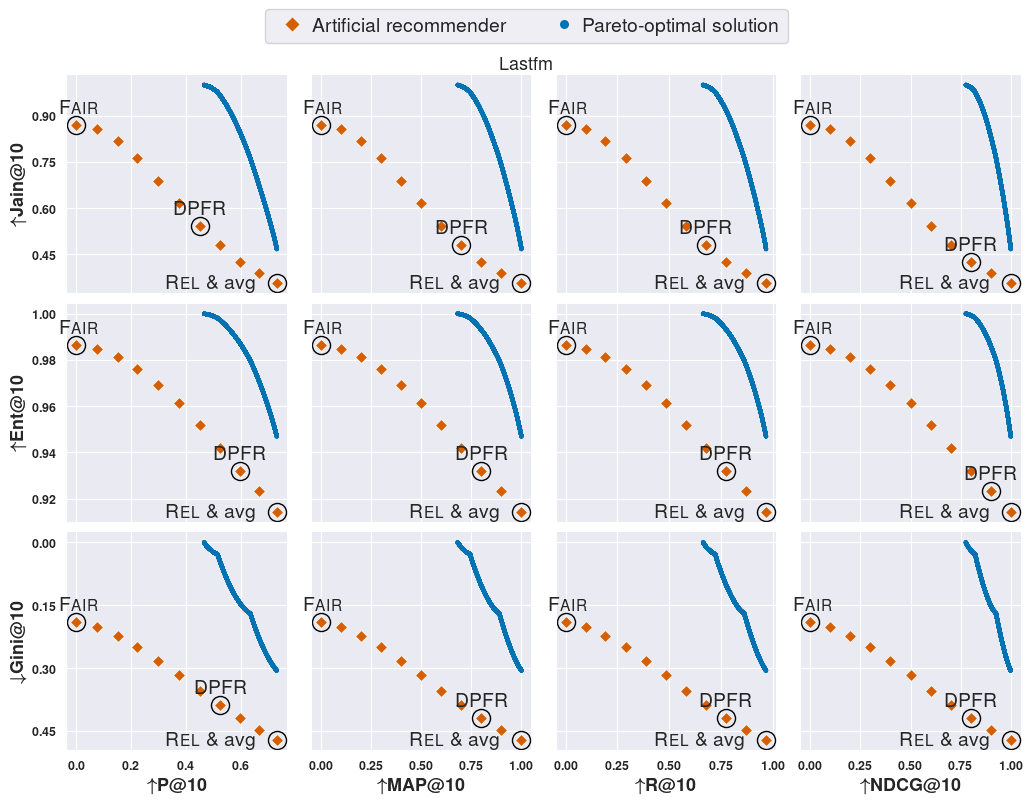

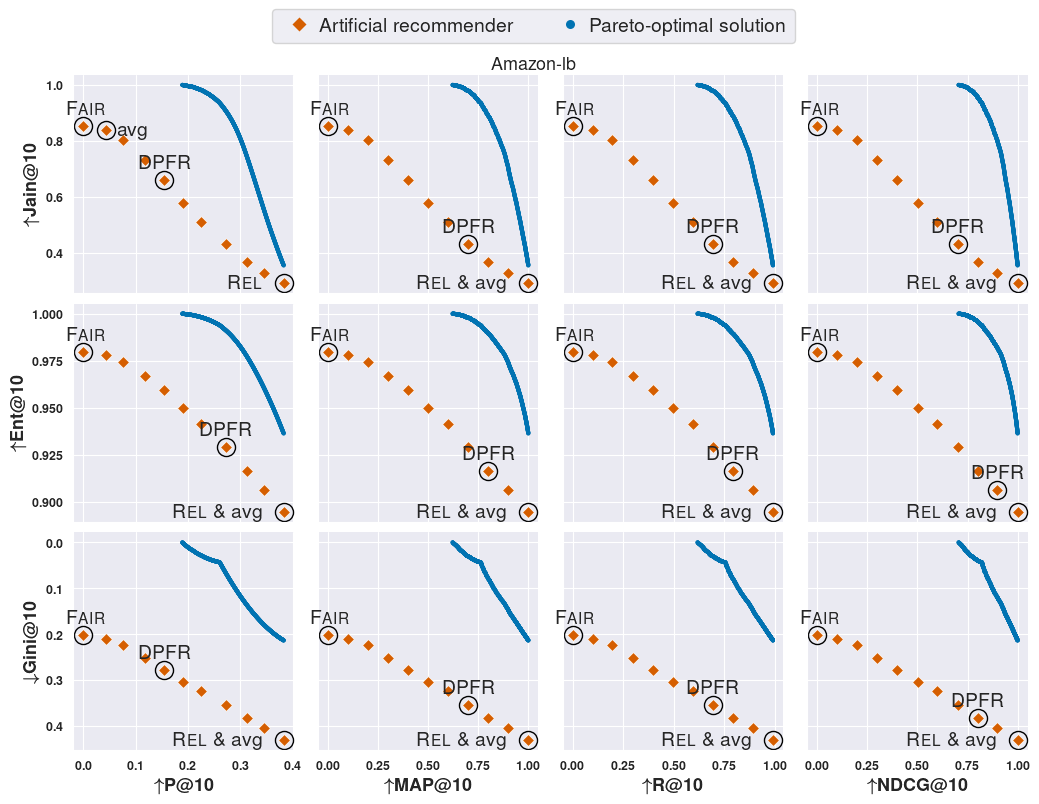

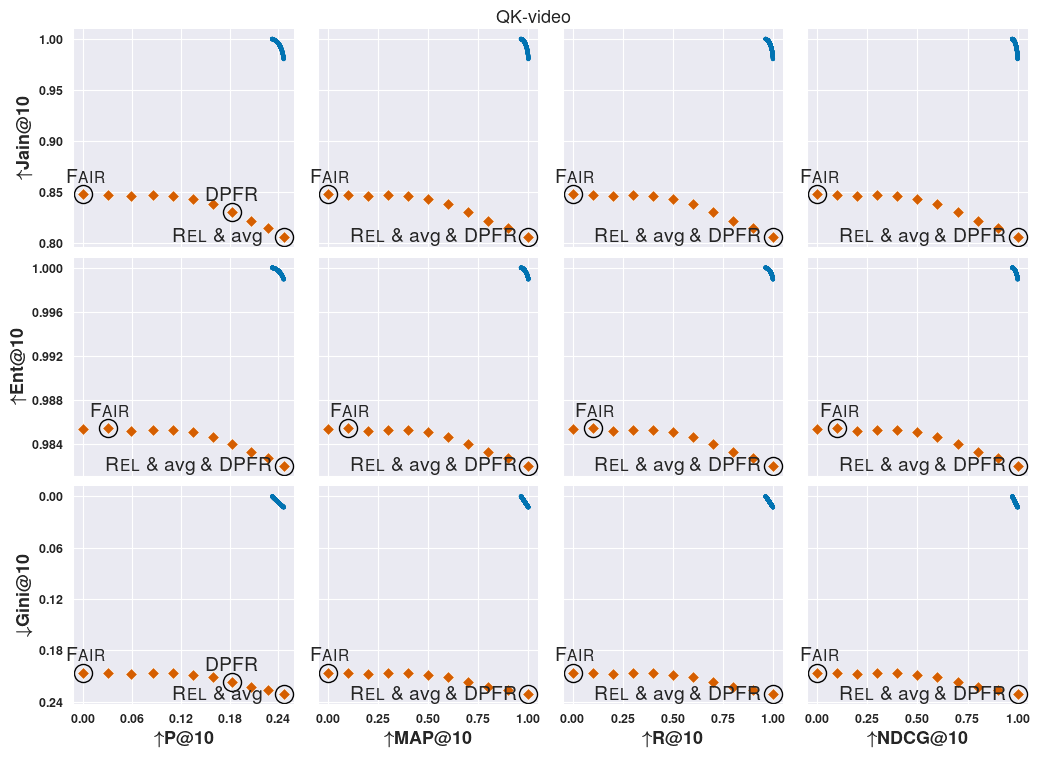

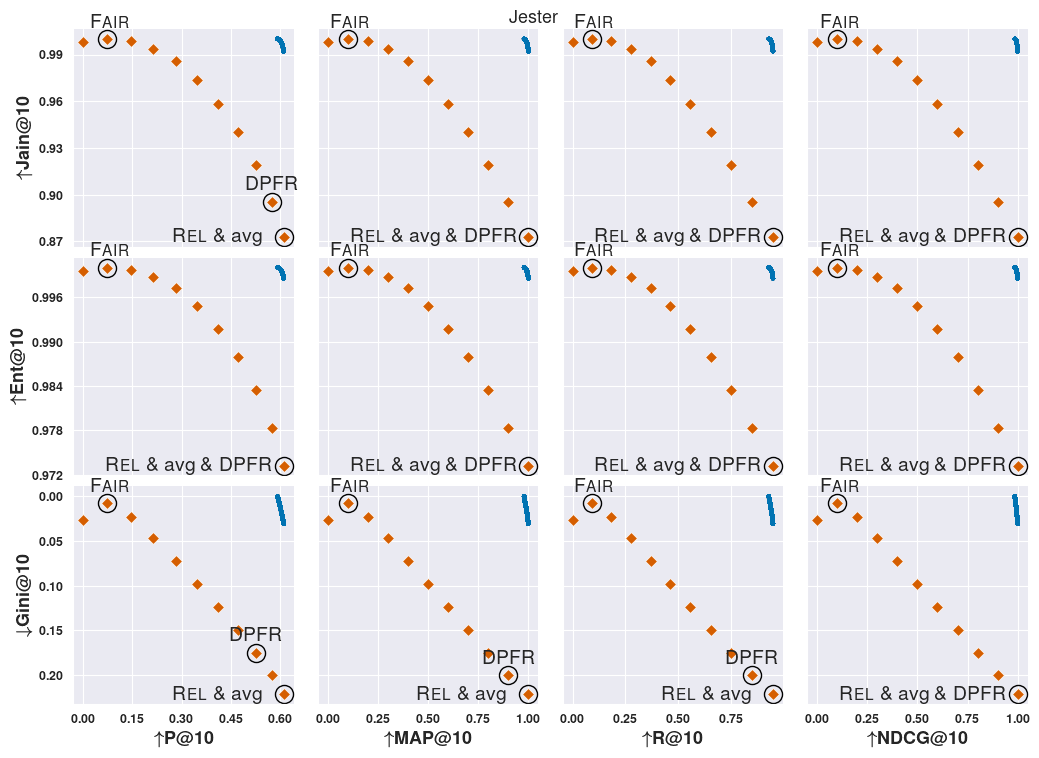

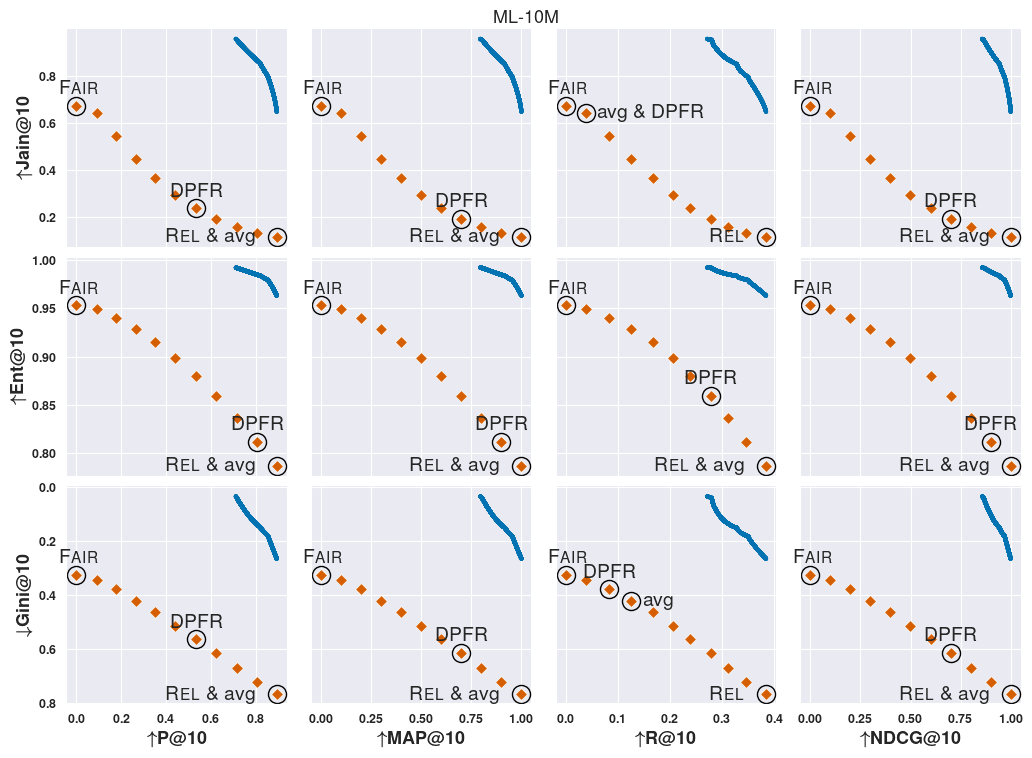

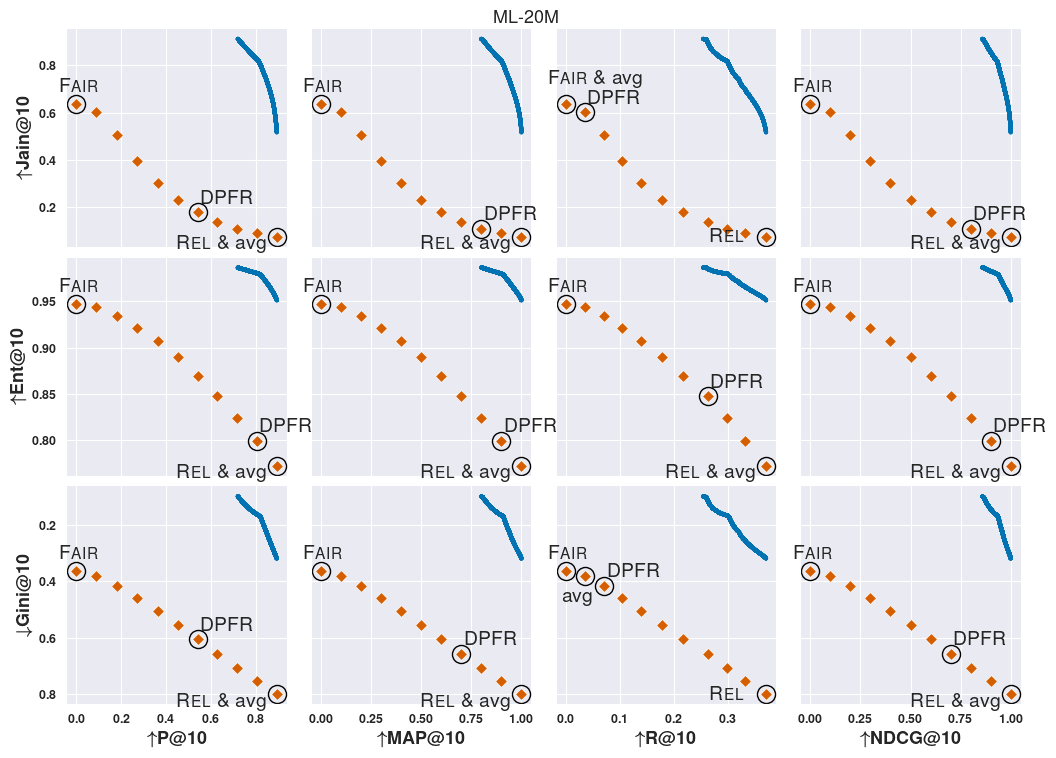

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.rcParams['figure.dpi'] = 100
best_model_annotated_full = plot_pareto_for_paper(combined_df_full, artificial_model_distance_dict_full)

In [6]:
pd.DataFrame(best_model_annotated_full).to_pickle("artificial/best_model.pickle")